In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsolutePercentageError as MAPE
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import Dataset_Class as DC



# USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE = 'cpu'
RANDOM_SEED = 2023



torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)



# class CustomDataset(Dataset):
#     def __init__(self, X, Y):
#         self.X = X
#         self.Y = Y
        
#     def __getitem__(self, index):
#         return (self.X[index], self.Y[index])
    
#     def __len__(self):
#         return len(self.X)


# TODO: 211224 데이터가 이상해서 삭제했기 때문에 수정할 곳이 왕왕왕왕 많다!!!!!!!!!!!!!!!!!            --->      일단 이 파일에서 필요한 부분 수정함... load:234개, X, Y 각각 233개
# TODO: PV 예측에 사용할 데이터가 변경돼서 수정할 곳이 저어어어엉말 많다!!!!!!!!!!!!!!
load = pd.read_csv("./processed_data/week_2021_load.csv", index_col = 0)
# X: 210104-211229, Y: 210105-211230 / 234x24
X = load.iloc[0:233,:]
Y = load.iloc[1:234,:]
X = torch.FloatTensor(X.values)
Y = torch.FloatTensor(Y.values)


dataset = DC.CustomDataset(X, Y)
data_len = dataset.__len__()


# dataset seperation
train_size = int(data_len * 0.8)
mini_train_size = int(train_size * 0.8)


# train_data, valid_data, validation_data, test_data
# 고민: data split 과정에서 randomness를 부가해야 할까?
# ==> training data에만 shuffle, 이외 validataion, testing에서는 shuffle 없음. 즉, random_split도 사용하지 않음.
train_data = DC.CustomDataset(X[:train_size], Y[:train_size])                                 # 186개   210104 ~ 211015
test_data = DC.CustomDataset(X[train_size:], Y[train_size:])                                  # 47개    211018 ~ 211229
mini_train_data = DC.CustomDataset(X[:mini_train_size], Y[:mini_train_size])                  # 148개   210104 ~ 210819
valid_data = DC.CustomDataset(X[mini_train_size:train_size], Y[mini_train_size:train_size])   # 38개    210820 ~ 211015

mini_train_dataloader = DataLoader(mini_train_data, batch_size = 32, shuffle = True)
valid_dataloader = DataLoader(valid_data, batch_size = valid_data.__len__(), shuffle = False)
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = test_data.__len__(), shuffle = False)

In [2]:
load.__len__()

234

[Text(0, 0, '1'),
 Text(18, 0, '2'),
 Text(35, 0, '3'),
 Text(57, 0, '4'),
 Text(78, 0, '5'),
 Text(97, 0, '6'),
 Text(112, 0, '7'),
 Text(134, 0, '8'),
 Text(155, 0, '9'),
 Text(176, 0, '10'),
 Text(195, 0, '11'),
 Text(216, 0, '12')]

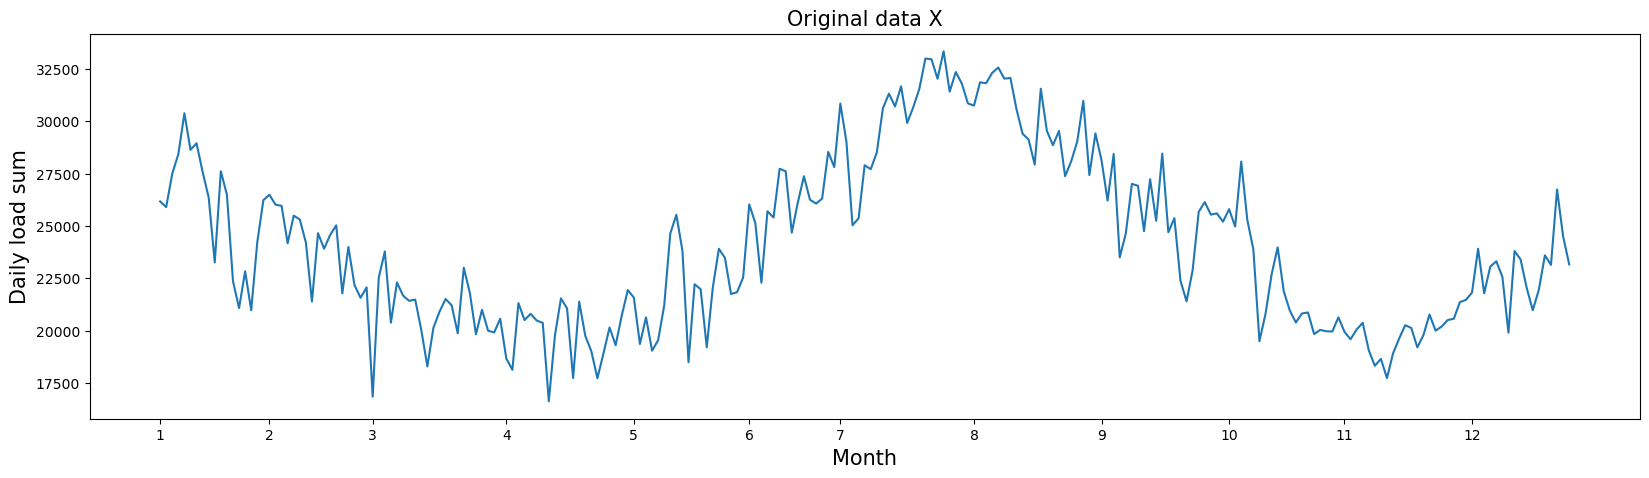

In [3]:
label_interval = [18, 17, 22, 21, 19, 15, 22, 21, 21, 19, 21, 18]
# data = X.detach().numpy().reshape(-1)                      # version 1: 데이터를 변형하지 않고 그대로 나타낸다. 1 row당 24 columns가 있으니 reshape 처리하면 하루가 24개의 데이터로 이루어지게 된다.
data = torch.sum(X, axis=1).detach().numpy().reshape(-1)     # version 2: 데이터를 변형한다. 하루의 load를 합계하여 그래프를 더 보기 좋게 만든다.

# Create figure and plot the data
fig = plt.figure(figsize=(20,5))
ax = plt.axes()
ax.plot(data)

plt.title('Original data X', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Daily load sum', fontsize = 15)

# Set the x-tick positions and labels
x_ticks = []
x_labels = []
for i, interval in enumerate(label_interval):
    # start = sum(label_interval[:i])*24       # 하루에 24개의 feature가 있으니까 24를 따로 곱해주었다.
    start = sum(label_interval[:i])            # X를 그대로 사용하지 않고, 일자별로 load 합계를 구했기 때문에 feature 개수인 24를 곱하지 않는다.
    x_ticks.append(start)
    x_labels.append(f'{i+1}')

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)


In [4]:
x_ticks

[0, 18, 35, 57, 78, 97, 112, 134, 155, 176, 195, 216]

In [5]:
print(torch.max(torch.sum(X, axis=1)), torch.min(torch.sum(X, axis=1)), torch.max(torch.sum(X, axis=1))-torch.min(torch.sum(X, axis=1)))

tensor(33337.7969) tensor(16628.8984) tensor(16708.8984)


In [6]:
# # min max 날짜 찾아내는 코드 -->  근데 쓸모없게 됨..
# def findDate(value):
#     for i in range(0,24):
#         for e in load['{}'.format(i)]:
#             if e == value:
#                 print(i)
#                 return i

# # 활용 예시
# print(torch.max(X), torch.min(X))  # X, Y 모두 max, min 차이가 같다.
# value = 33337.7969    
# load.loc[load['{}'.format(findDate(value))] == value]

In [7]:
## validation set을 사용하는 방법에 대해 고민해보아야 할 듯. 1. with statement 사용하기 2. evaluate function 만들어서 validation set을 epoch마다 evaluate하기. 이때 train function에서 epoch을 분리해서
## 따로 만들고 epoch별로 train, evaluate 진행. ==> 2번 선택!
def train(model, trian_dataloader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    for (x, y) in train_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        output = model(x)
        train_loss = criterion(output, y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_sum += train_loss
    
    return (loss_sum/len(trian_dataloader.dataset)).item() # loss of each epoch


def evaluate(model, valid_dataloader):
    model.eval()
    with torch.no_grad():
        for (x, y) in valid_dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
                
            output = model(x)
            
        return output, y

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(24, 256)
        self.fc2 = nn.Linear(256, 1024)
        # self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(1024, 24)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.batch_norm2 = nn.BatchNorm1d(1024)
        # self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        # x = self.fc3(x)
        # x = self.relu(x)
        output = self.fc4(x)
        return output
    

In [9]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(24, 64)
#         self.fc2 = nn.Linear(64, 512)
#         # self.fc3 = nn.Linear(1024, 128)
#         self.fc4 = nn.Linear(512, 24)
#         self.relu = nn.ReLU()
#         self.batch_norm1 = nn.BatchNorm1d(64)
#         self.batch_norm2 = nn.BatchNorm1d(512)
#         # self.sig = nn.Sigmoid()
    
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.batch_norm1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.batch_norm2(x)
#         x = self.relu(x)
#         # x = self.fc3(x)
#         # x = self.relu(x)
#         output = self.fc4(x)
#         return output
    

In [10]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


model = Net().to(DEVICE)

EPOCHS = 5000
LEARNING_RATE = 0.0001
# MOMENTUM = 0.9

# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss()
mini_train_loss_arr = []
val_loss_arr = []


# model training and validation
best_val_loss = float('inf')
best_val_epoch = 0


for epoch in range(EPOCHS):
    mini_train_loss = train(model, mini_train_dataloader, optimizer, criterion)
    mini_train_loss_arr.append(mini_train_loss)
    val_output, val_y = evaluate(model, valid_dataloader)
    val_loss = criterion(val_output, val_y)
    val_loss_arr.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch
        # torch.save(model.state_dict(), './model.pt')
        # print('state_dict format of the model:\n{}'.format(model.state_dict()))
    if epoch % 200 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}  |  Val Loss {:.6f}'.format(
            epoch, EPOCHS, mini_train_loss, val_loss))


print('-'*80)
print('The Best Epoch: {}  |  The Best Validation Error: {:.6f}'.format(
    best_val_epoch, best_val_loss
))

Train Epoch:    0/5000  |  Train Loss 47486.519531  |  Val Loss 1193417.375000
Train Epoch:  200/5000  |  Train Loss 39727.085938  |  Val Loss 972939.875000
Train Epoch:  400/5000  |  Train Loss 30147.972656  |  Val Loss 705315.500000
Train Epoch:  600/5000  |  Train Loss 21389.988281  |  Val Loss 426419.593750
Train Epoch:  800/5000  |  Train Loss 13825.822266  |  Val Loss 231516.296875
Train Epoch: 1000/5000  |  Train Loss 7089.688477  |  Val Loss 146847.562500
Train Epoch: 1200/5000  |  Train Loss 3478.694580  |  Val Loss 54089.437500
Train Epoch: 1400/5000  |  Train Loss 1330.471313  |  Val Loss 21172.494141
Train Epoch: 1600/5000  |  Train Loss 590.338501  |  Val Loss 10615.641602
Train Epoch: 1800/5000  |  Train Loss 622.273743  |  Val Loss 8895.041016
Train Epoch: 2000/5000  |  Train Loss 366.858276  |  Val Loss 8425.211914
Train Epoch: 2200/5000  |  Train Loss 392.597107  |  Val Loss 9174.569336
Train Epoch: 2400/5000  |  Train Loss 358.453217  |  Val Loss 8304.625977
Train Epo

In [11]:
best_val_epoch = 4994

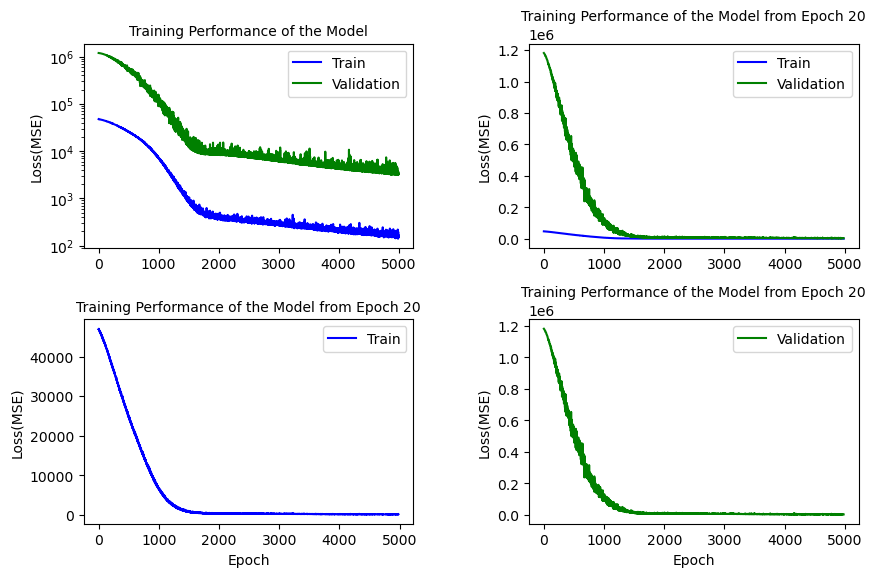

In [12]:
fig = plt.figure(figsize=(10,6))

FONT_SIZE = 10

plt.subplot(221)
plt.title('Training Performance of the Model', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
plt.yscale('log')
plt.plot(mini_train_loss_arr[0:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[0:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(222)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[20:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[20:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(223)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[20:], c = 'blue', label = 'Train')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(224)
plt.title('Training Performance of the Model from Epoch 20', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(val_loss_arr[20:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)

In [13]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


mae = nn.L1Loss()
mape = MAPE()


for epoch in range(best_val_epoch):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    if epoch % 200 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}'.format(
            epoch, best_val_epoch, train_loss))

test_output, test_y = evaluate(model, test_dataloader)

test_mse = criterion(test_output, test_y)
test_mae = mae(test_output, test_y)
test_mape = mape(test_output, test_y)


print('Test Loss')
print('MSE: {:.6f}'.format(test_mse))
print('MAE: {:.6f}'.format(test_mae))
print('MAPE(%): {:.6f}'.format(test_mape*100))

Train Epoch:    0/4994  |  Train Loss 121.918777
Train Epoch:  200/4994  |  Train Loss 138.648987
Train Epoch:  400/4994  |  Train Loss 155.652054
Train Epoch:  600/4994  |  Train Loss 105.729294
Train Epoch:  800/4994  |  Train Loss 107.617867
Train Epoch: 1000/4994  |  Train Loss 94.068611
Train Epoch: 1200/4994  |  Train Loss 105.147682
Train Epoch: 1400/4994  |  Train Loss 98.217094
Train Epoch: 1600/4994  |  Train Loss 93.341911
Train Epoch: 1800/4994  |  Train Loss 88.065300
Train Epoch: 2000/4994  |  Train Loss 85.111885
Train Epoch: 2200/4994  |  Train Loss 75.545647
Train Epoch: 2400/4994  |  Train Loss 72.708611
Train Epoch: 2600/4994  |  Train Loss 74.087982
Train Epoch: 2800/4994  |  Train Loss 72.487495
Train Epoch: 3000/4994  |  Train Loss 73.469048
Train Epoch: 3200/4994  |  Train Loss 76.356018
Train Epoch: 3400/4994  |  Train Loss 56.821472
Train Epoch: 3600/4994  |  Train Loss 66.011208
Train Epoch: 3800/4994  |  Train Loss 89.335472
Train Epoch: 4000/4994  |  Train L

In [14]:
def plot(i, length, output, Y):
    fig = plt.figure(figsize=(20, 5))
    plt.title('Actual and forecast load for 20 days', fontsize = 18)
    plt.xlabel('Time (h)', fontsize = 15)
    plt.ylabel('Load', fontsize = 15)
    plt.plot(Y.detach().numpy()[i:i+length,:].reshape(-1), c='blue', label = 'Actual data')
    plt.plot(output.detach().numpy()[i:i+length,:].reshape(-1), c='red', label = 'forecast data')
    plt.legend(loc='lower right', fontsize = 13)


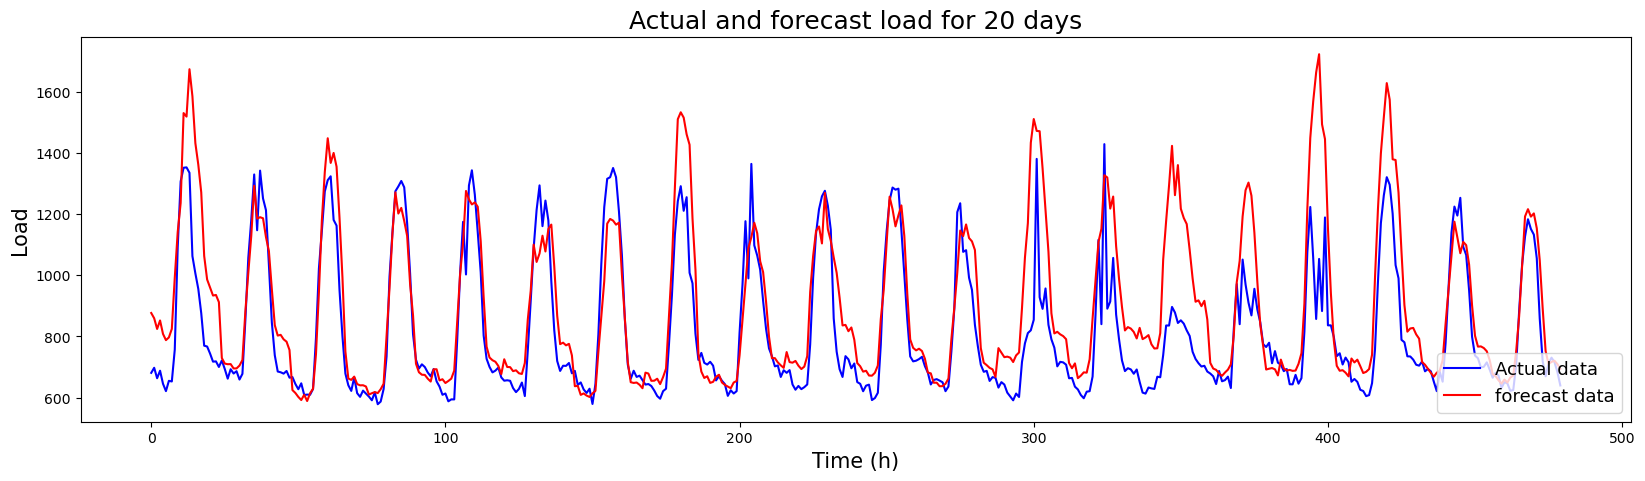

In [15]:
# 211019 ~ 211116
plot(1, 20, test_output, test_y)

In [16]:
torch.save(model.state_dict(), './model_pt/model_1024_BN.pt')

In [18]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


mae = nn.L1Loss()
mape = MAPE()

model = Net().to(DEVICE)

EPOCHS = 5000
LEARNING_RATE = 0.0001
# MOMENTUM = 0.9

# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss()
mini_train_loss_arr = []
val_loss_arr = []


model.load_state_dict(torch.load(f'./model_pt/model_1024_BN.pt'))
test_output, test_y = evaluate(model, test_dataloader)

test_mse = criterion(test_output, test_y)
test_mae = mae(test_output, test_y)
test_mape = mape(test_output, test_y)


print('Test Loss')
print('MSE: {:.6f}'.format(test_mse))
print('MAE: {:.6f}'.format(test_mae))
print('MAPE(%): {:.6f}'.format(test_mape*100))

Test Loss
MSE: 20742.689453
MAE: 100.512085
MAPE(%): 11.208912


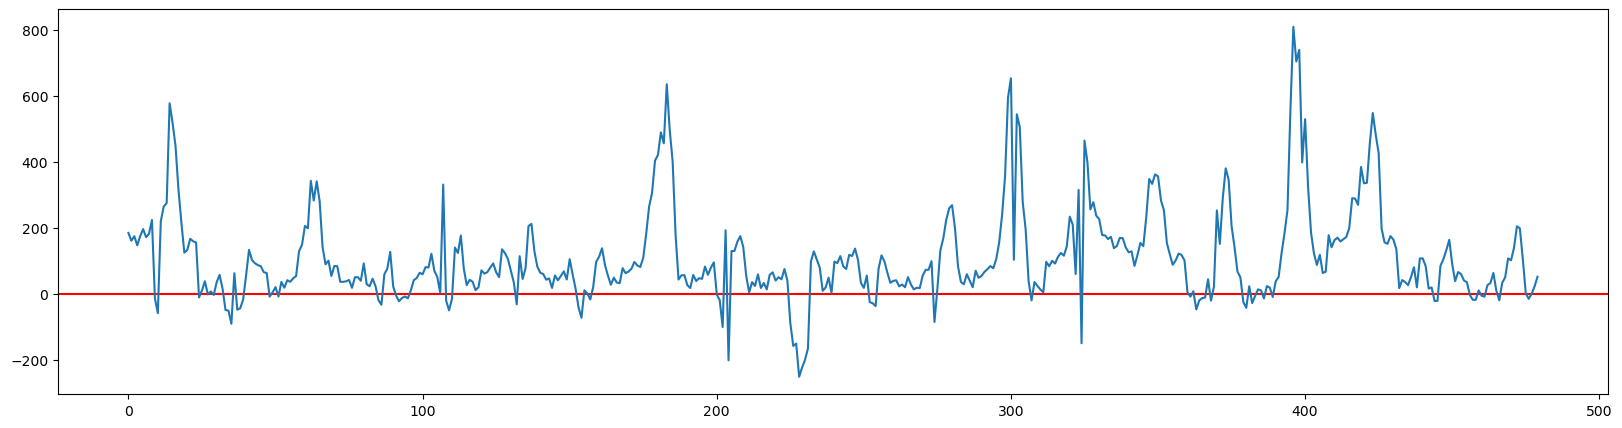

In [17]:
diff=(test_output-test_y)

plt.figure(figsize=(20,5))
plt.axhline(y=0, c='r')
plt.plot(diff.detach().numpy()[1:21].reshape(-1))
